filename: 00086.csv    |  pixel_size: 154  |  time_step: 20
frame_start: 0  |    frame_end: -1  |  bin_size: 20
processing: none  |  plot_type: basal3  |  title: RecBCD.csv
X_axis_label: x (nm)  |  Y_axis_label: y (nm)  |  Z_axis_label: Time (ms)
end
end1
end3
end2
end
Graphing block 1 has completed
Graphing block 2 has completed


<IPython.core.display.Javascript object>


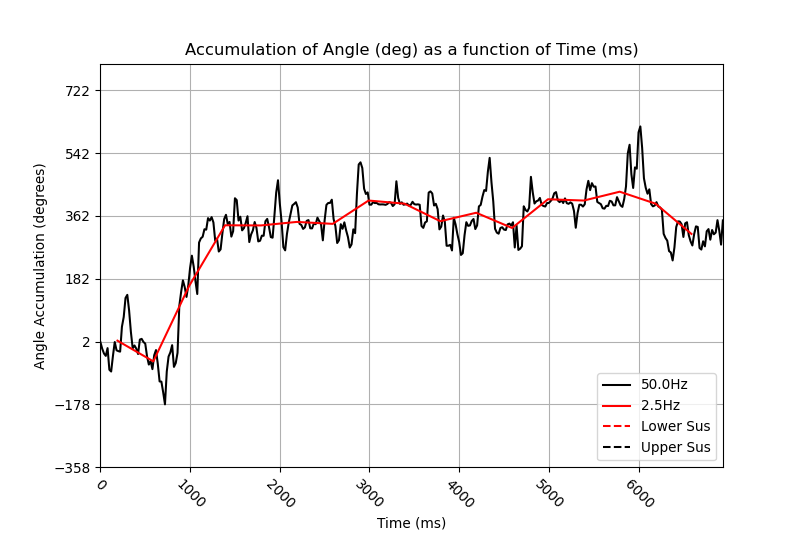

before is running
after is running
Wall time: 530 ms
Parser   : 132 ms


In [11]:
%%time
"""
4.4.2022

@author: Jerry Wu + Claire Rickets

Hi Team, 

Below is the code that will take Ryan's .tr files and process them into various visualization forms. 

As a reminder the work flow is as follows:

Workflow step 1. Run code with ['find_center_coordinates': 'yes' ], AND #Initial required parameters filled out accordingly
    This generates the center guess which will be used by the next run to generate graphs.
Worflow step 2. Run code with ['find_center_coordinates': 'no' ], AND input the 'plot_type' you would like to use 

For any questions feel free to call at 914-806-1369 or email at jdw010@ucsd.edu

Features of interest
1. Plots:
        - To generate the circular 2D plot of the trajectory, use 'plot_type': "2D",
        - To scope which points are questionable and thus removed from the below plot, use 'plot_type': "radius_filter"
        - To generate the continuous angle plot from filterted data, use 'plot_type': 'angular_continuous_filtered',
                This plot identifies three types of erroneous data: 
                    1+2) data above or below distance of statistical (standard devation) boundary set
                    3) invalid data from .tr files, which were outputted as (0,0)
2. if you want to export variables within the function, the last return in the function is the one to use. 
        - *********NOTE
        - I have set this block to export the variable data which is the final data table of the relevant data. 
          This causes a non fatal when finding center in Workflow step 1. 
          This error can be removed by deleting the data after the last return and data as an exported variable. 
            (         return data <-- this one

               data = DORA(**parameters))       <-- this one also          




"""


import numpy as np
import pandas as pd
import plotly.graph_objects as go 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d.art3d import Line3DCollection 
from matplotlib import ticker
import math
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from IPython import display
import random
import itertools
from matplotlib.widgets import Slider, Button
from IPython.core.display import HTML
matplotlib.rcParams['animation.embed_limit'] = 2**128 #allows for large java HTML
import mplcursors # Jerry adds way to hover data points in matplotlib rather than plotly
import scipy.stats as stats # added to calculate z-score for Radius filtering

#affects plot presentation
%matplotlib inline


parameters = {
##############################################Initial required parameters    [COMEBack]
'file_name': '00086.csv',
'pixel_size': 154, # in nanometers
'time_step': 20, # miliseconds per frame in trajectory movie
'frame_start': 0, # enter 0 to start from beginning of dataset
'frame_end': -1, # enter -1 to end at the last value of the data set
'auto_frame_end': 'yes', # yes to cut off all values after first 0,0 = x,y
'find_center_coordinates': 'no', # 'yes' for first run, 'no' after center has been determined
##############################################Secondary required parameters  
'plot_type': "basal3",
        #Graphing options: 
            #2D: Colorful 2D visulization of the rotor from above
            #3D: 2D plot but time is an axis
            #grid: a grid of little snippets of the data
            
            #angular: angle vs time, but it's not cummulative and resets at 360 to 0 (Claire)
            #angular_continuous: Claire's Calculation of a cummulative angle
            #radius_filter: Demarcate the sus data points that will be eliminated from calculations
            #find_sus_angle_CR: Indicate sus angles within angular_continuous by Claire
            #find_sus_angle_JW: Indicate sus angles within angular_continuous by Jerry 
            #angular_continuous_filtered: Angular Continuous recalculated with sus points filtered. Sus skips indicated.  
            
            #Experiment tailored:
                #basal1: outmoded 
                #basal2: outmoded 
                #basal3: Angular Continuous but for [COMEBACK]
    
            #interactive: Interactive graph
            #animated: animated trajectory in notebook
            #HTML: Animated trajectory in a new window. May run better 
'bin_size': 20, # bin size for downsample/filter processing
'display_center': "yes", # "yes" enabbles center display of center coordinates if 2D or Find sus angle
'processing': "none", # enter downsample, filter, or none
'unit': "nm",  # enter pixel or nm 
####################################################Labeling parameters 
'title': "RecBCD.csv",
'x_axis_label': "x (nm)",
'y_axis_label': "y (nm)",
'z_axis_label': "Time (ms)",
####################################################Formatting parameters for 'radius_filter'
'rad_filter_type_lower': 'nm',   #enter 'zscore' or 'nm' for choice 
'rad_filter_type_upper': 'zscore',   #enter 'zscore' or 'nm' for choice 
'z_up': 3, # enter an upper bound for z score. 
'z_down': -3, # enter a lower bound for z score
'dist_low': 30, # lower bound for ABS of Radius filter
'dist_high': 70, # upper bound for ABS of Radius filter
####################################################Formatting parameters 'grid' plot
'frames_per_plot': 195, #refers to grid plot
'columns': 7,# columns of plots (grid plot)
####################################################Formatting parameters 'animation' plot
'frame_speed': 20, # for animation only (ms)
'tail_length': 50, # for animation only
####################################################Formatting parameters for 'angular_continuous_filtered' plot
'graph_style': 'line', #enter 'line' or 'scatter' for a line graph or a scatter plot. Line plot makes up points when hovered
################################################### #Formatting parameters all plots  
'pixel_min': -0.75, # setting min/max axis range (pixel)
'pixel_max': 0.75,
'axis_increment_pixel': 7, #change axis increments for nicely fitting tick marks (pixel)
'nm_min': -150, # setting min/max axis range (nm)
'nm_max': 150,
'axis_increment_nm': 7, #change axis increments for nicely fitting tick marks (nm)
'fig_size_x': 40, #adjust display parameters for graphs to fit nicely, mostly used for 'grid' plot 
'fig_size_y': 40,
####################################################Save figures and Data Table
'save_plot': 'no',
'save_filtered_table': 'yes', # 'yes' saves final data table "data" as a csv file
} 


def DORA(file_name,pixel_size,time_step,frame_start,frame_end,auto_frame_end,find_center_coordinates,bin_size,display_center,processing,plot_type,title,x_axis_label,y_axis_label,z_axis_label,unit,rad_filter_type_lower,rad_filter_type_upper,z_up,z_down,dist_low,dist_high, frames_per_plot, columns, pixel_min, pixel_max, nm_min, nm_max,axis_increment_pixel,axis_increment_nm, fig_size_x, fig_size_y, frame_speed, tail_length, graph_style, save_plot, save_filtered_table):
       
              
        print(*['filename:', file_name, '   | ' , 'pixel_size:', pixel_size , ' | ' , 'time_step:', time_step])
        
        print(*['frame_start:', frame_start,' |   ','frame_end:', frame_end, ' | ', 'bin_size:', bin_size])
        
        print(*['processing:', processing, ' | ',  'plot_type:', plot_type,' | ' ,'title:', title])
        
        print(*['X_axis_label:',x_axis_label,' | ',  'Y_axis_label:',y_axis_label ,' | ' ,'Z_axis_label:', z_axis_label])
        if plot_type == 'grid':
            print(*['columns:', columns, '|', 'frames_per_plot:', frames_per_plot])
        if plot_type == 'animated':
            print(*['frame_speed:', frame_speed, '|', 'tail_length:', tail_length])
        if plot_type == 'radius_filter':
            print(*['Radius Filtering Style Lower:', rad_filter_type_lower])
            if rad_filter_type_lower == 'zscore':
                print(*['Lower Z-Score:', z_down])
            else:
                print(*['Lower Dist:', dist_low])
            print(*['Radius Filtering Style Upper:', rad_filter_type_upper])
            if rad_filter_type_upper == 'zscore':
                print(*['Upper Z-Score:', z_up])
            else:
                print(*['Lower Dist:', dist_high])
        
    
        #read data file into a pandas data frame, add an index counter, and label columns
#         data = pd.read_csv(file_name, header = None)
#         data = data.dropna()
#         data['index'] = range(len(data))
#         data.columns = ['X position', 'Y position','index']
#         data=data[['index','X position','Y position']



        

        #I will analyze the raw data from Ryan's code as pre_data and then covert that into two separate parts 
        #1) (data) the data formatted as arrays to be graphed [necessary numbers only]
        #2) (data_back) the data formated as a Dataframe for record keeping [NaN placed where sus value lies] 
        pre_data = pd.read_csv(file_name, header = None) # read the csv file intended 
#         pre_data = pre_data.dropna()  # drop all NaN values?
        pre_data['index'] = range(len(pre_data)) # create an array increasing in steps of
        pre_data.columns = ['X position', 'Y position','index'] # label the columns
        pre_data = pre_data.iloc[:,[2,0,1]] # reorganize the columns 
        ind_invalid_reading = pre_data['X position']== 0 # create a boolean array of where 1s are when x position is 0 or invalid
        ## this is bc Ryan's code exports invalid readings as (0,0)
        
        if auto_frame_end == 'yes':
            find_first_0 = (pre_data["X position"] == 0) & (pre_data["Y position"] == 0)
            pre_x = pre_data["X position"].copy()
            pre_x = pre_data[find_first_0]
            my_first_0 = pre_x.index[0]
            frame_end = my_first_0

        
        #SEPARATE data into front and back end (front==graphing ; back == tables)
        data = pre_data[~ind_invalid_reading].copy() # if the index is not invalid (or valid) keep it and store in data
        data_back = pre_data[ind_invalid_reading].copy() # section the pre data for all the invalid values
        
        
        #in data back develop a time colomn
        data_back['Time (ms)'] = data_back['index']*time_step
        
        data_back['X position'] = np.nan #set all target x positions to NaN, if the reading was sus
        data_back['Y position'] = np.nan # set all target y positions to NaN, if the reading was sus 
        data_back['Sus Type'] = 'Invalid Reading'
        
        
            
        ####################################### CENTERING ALGORITHM ###############################################
        if find_center_coordinates == 'yes':
            #establish empty lists
            ave_y = []
            ave_x = []
            stand = []
            
            #find uniform guesses in range of max and min unaltered data values for y position
            #THE NUMBER OF UNIFORM GUESSES IS CURRENTLY HARD CODED AT 50 FOR X AND Y, CULMULITIVE 2,500
            guess_y = np.linspace(data.iloc[frame_start:frame_end,2].max(), data.iloc[ frame_start:frame_end,2].min(), 50)
            #put into list
            guess_y = guess_y.tolist()
            # find guesses for x position
            guess_x =np.linspace(data.iloc[frame_start:frame_end,1].max(), data.iloc[frame_start:frame_end,1].min(), 50)
            guess_x = guess_x.tolist()
            
            

            #permute each x and y center guess together to create 10,000 unique center guesses
            center_guesses = list(itertools.product(guess_x, guess_y))
            # store center guesses in dataframe
            c = pd.DataFrame(center_guesses, columns = ['X','Y'])
            # set up list to store average distances (radius) of circular trajectory path
            ave_distance = []
            # set up list to store standard deviation of distances to each point in the trajectory
            stand = []
            j = 0
            for j in range(len(c)): # chnage to range(len(c))
                # find the distance between each point in a dataframe against guess[i]
                distance = np.power(((data["X position"]- c['X'][j])**2 + (data["Y position"]- c['Y'][j])**2),0.5)
                # store distances in a dataframe
                d = pd.DataFrame(distance, columns = ['distance'])
                # find average of distances (this would be the radius)
                ave_d = d['distance'].mean(axis = 0)
                # store all average distances from each guess[i] distance dataframes into list
                ave_distance.append(ave_d)
                # find standard deviation of center distance from each point in trajectory for each guess[i]
                std = d['distance'].std(axis = 0)
                # store each standard deviation in a list  
                stand.append(std)

                j += 1
            # put radius and std lists in a dataframe    
            c['average_distance'] = ave_distance
            c['std'] = stand
          

            # this block finds the row with the lowest std, the corresponding radius and x,y coordinates for the center
            # want to return row with lowest std
            target_row = c['std'].idxmin()
            # x center guess with lowest std
            center_x = c.loc[target_row,'X']
            # y center guess with lowest std
            center_y = c.loc[target_row,'Y']
            #radius of trajectory
            dist = c.loc[target_row,'average_distance']

 
            # Our regularly scheduled 2D graphing program
            fig = plt.figure(figsize=(6,6), dpi=100)
            ax = fig.add_subplot(111)#121 # 1X1 grid plot 1, subplot(222) would be 2X2 grid plot 2, (223)--> 2X2 plot 3

            #color bar color scheme assignment, graph type, colorbar size and alignment
            colors = cm.viridis(np.linspace(0, 1, len(data.iloc[frame_start:frame_end,1])))
            ax.scatter(data.iloc[frame_start:frame_end,1], data.iloc[frame_start:frame_end,2],c= colors, alpha = 0.7)
            
            # add a red dot to indicate center of trajectory
            ax.scatter(center_x, center_y, color = 'red')
            plt.text(x = center_x +0.02, y = center_y +0.02, s = 'algorithm centering')

            # add a circle with center at our best guess and radius derived from our best guess 
            circle = plt.Circle((center_x, center_y), dist, color='r', fill=False)
            ax.add_patch(circle)
            
            #Colorbar parameters below if we want one in the future

            # cbar = plt.colorbar(p, label= 'time' ,                asdfshrink= .82) #

            # #setting the ticks on the colorbar to span the length of the time column with 6 increments
            # cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1]) 

            # tix = np.linspace(0,len(data),6, dtype = int) # forces colorbar to show time in integers
            # tix_c = tix*20
            # cbar.set_ticklabels(tix_c) 
            
            plt.axis('square') #INTEGRAL to maintaining aspect ratio
            plt.xticks(rotation=45)
            ax.set_xlabel('X position (unaltered)', fontweight = 'bold', fontsize = 14)
            ax.set_ylabel('Y position (unaltered)', fontweight = 'bold', fontsize = 14)

            # plot title and font configurations
            plt.title('Algorithm Center Guess' , fontweight = 'bold', fontsize = 16)
            plt.show()
            
            
            #below is the key to maintaining the value of the center variable once the user satisfaction is achieved
            global center
            
            center =(center_x,center_y)
            
            print('The center is {0}'.format(center))
            print('If the center is satisfactory, change the find_center_coordinates parameter to no')
            print('If the center is unsatisfactory, adjust the frame_start and frame_end parameters and try again')
            
            return
        
        
        print('end') 
            

        
        
        
        ## DATA NORMILIZATION AND UNIT ASSIGNMENT ##

        # find the average of X and Y column respectively
        ave = data.mean(axis=0)
        

        #substract averages from each column to find displacement, store into new columns
        data["X displacement (pixels)"] = data['X position'] - center[0]
        data["Y displacement (pixels)"] = data['Y position'] - center[1]
        # mutiply pixel displacement columns by scaler to find nm displacement, store in new columns
        data["X displacement (nm)"] = data['X displacement (pixels)']*pixel_size
        data["Y displacement (nm)"]= data['Y displacement (pixels)']*pixel_size
        # multiply the index counter column by time_step to make a time step column, store into new column 
        data["Time (ms)"] = data['index']*time_step
        # drop all NaN values *not a number
        data = data.dropna() 
        #drop NAN try to conserve time (what if we have NAN in x and not in Y? need to drop the whole row)
        
        
        print('end1')
        
        ############################Recalculation of center using distance forumla -- Jerry
        #Radius Calculation from distance formula
        data['Radius (nm)'] = np.power(((data["X displacement (nm)"])**2 + (data["Y displacement (nm)"])**2),0.5)
        
        #Z score calculation
        data['z-score Rad'] = stats.zscore(data["Radius (nm)"])
        
        #Angle Calculation
        
            #Radian to degree conversion factor
        r2d = 180/np.pi
            
            #Take Arc Tan function of x and y coord to get radius. Arctan 2 makes Quad 3 and 4 negative. 
        data['Angle'] = -np.arctan2(data['Y displacement (nm)'],data['X displacement (nm)'])*r2d
            
            #Make all Theta values positive equivalents
        data.loc[data.Angle < 0, ['Angle']] += 360
            

        
        ## PROCESSING BLOCK ##
        print('end3')

            
        ##Simple Moving Average or "filter" dataframe:
        ma = pd.DataFrame(data.iloc[:,0],columns=['index'])

        window = bin_size
        #Built in simple moving average function is applied to normal data and stored in dataframe "ma"
        ma['X movement' ] = data.iloc[:,1].rolling(window=window).mean()
        ma['Y movement'] = data.iloc[:,2].rolling(window=window).mean()
        ma['X displacement (pixels)'] = data.iloc[:,3].rolling(window=window).mean()
        ma['Y displacement (pixels)'] = data.iloc[:,4].rolling(window=window).mean()
        ma['X displacement (nm)'] = data.iloc[:,5].rolling(window=window).mean()
        ma['Y displacement (nm)'] = data.iloc[:,6].rolling(window=window).mean()
        ma['Time (ms)'] = data.iloc[:,7].rolling(window=window).mean()

        #This block delets the null spaces in the new dataframe and realigns the data
        ma = ma.apply (pd.to_numeric, errors='coerce')
        ma = ma.dropna()
        ma = ma.reset_index(drop=True)
       
        
        
        
        ##Downsampling dataframe:
        da=pd.DataFrame(data.iloc[:,:])
        #divide original index by sample size and round to nearest whole number to 
        #achieve new index number underwhich the origial index is stored
        u= math.floor(frame_start/bin_size)
        v= math.floor(frame_end/bin_size)

        #isolate the column (if we print this it will show as a dataframe with 2 cols: indexes and time values)
        daT_column=da.iloc[:,7]
        daDY_column=da.iloc[:,6]
        daDX_column=da.iloc[:,5]
        daPY_column=da.iloc[:,4]
        daPX_column=da.iloc[:,3]
        daI_column=da.iloc[:,0]
        daX_column=da.iloc[:,1]
        daY_column=da.iloc[:,2]
        #We just want the values in the column
        daT = daT_column.values
        daDY = daDY_column.values
        daDX = daDX_column.values
        daPY = daPY_column.values
        daPX = daPX_column.values
        daI = daI_column.values
        daX = daX_column.values
        daY= daY_column.values
        #This function taken from https://stackoverflow.com/questions/10847660/subsampling-averaging-over-a-numpy-array
        # allows us to downsample by averages over a set number 
        #(change 'n' to the number of values you want to average over)
        def average(arr, n):
            end =  n * int(len(arr)/n)
            return np.mean(arr[:end].reshape(-1, n), 1)
        #Takes a column from our 'da' dataframe and runs the function over it
        #stores the new values in variables as an array (values in a row)

        #assigning each new row to a varialble
        Time = average(daT,bin_size)
        Index = average(daI,bin_size)
        Xda = average(daX,bin_size)
        Yda = average(daY,bin_size)
        Ydisnm = average(daDY,bin_size)
        Xdisnm = average(daDX,bin_size)
        YdisP = average(daPY,bin_size)
        XdisP = average(daPX,bin_size)

        #reshaping the data in a 1D column
        TimeT = Time[:, np.newaxis]
        YdisnmT = Ydisnm[:, np.newaxis]
        XdisnmT = Xdisnm[:, np.newaxis]
        YdisPT = YdisP[:, np.newaxis]
        XdisPT = XdisP[:,np.newaxis]
        XdaT = Xda[:, np.newaxis]
        YdaT = Yda[:,np.newaxis]
        IndexT = Index[:,np.newaxis]
        
        #stores in a new dataframe 'dsa' for: downsampling average
        dsa= pd.DataFrame(IndexT, columns=['index'])
        #appending to our data frame
        dsa['X movement'] = XdaT
        dsa['Y movement'] = YdaT
        dsa['X displacement (pixels)'] = XdisPT
        dsa['Y displacement (pixels)'] = YdisPT
        dsa['X displacement (nm)'] = XdisnmT 
        dsa['Y displacement (nm)'] = YdisnmT
        dsa['Time (ms)'] = TimeT
        
        print('end2')
        
        ## FOR MULTIPLE PLOTS
        # Function for 2D plot parameters (called when user asks for multiple plots)
        # the grid_plot graph type runs best when this function is defined here and is called under plot_type == grid_plot if statement
        def do_plot(ax):
            #regular graphing parameters for 2D graph (color of scatter, size, shape, tick marks, etc.)
            colors = cm.Greens(np.linspace(0, 1, len(z)))
            p=ax.scatter(x, y, c=colors)
            #fig = plt.figure(figsize=(6,6), dpi=100)
            tix = np.linspace(0,len(z),6)
            #tix_c = tix*time_step
            #cbar2.set_ticklabels(tix_c)
            plt.axis('square')
            plt.xticks(rotation=45)
            if unit == "pixel":
                ax.set_xlim(pixel_min, pixel_max) 
                ax.set_ylim(pixel_min, pixel_max)
                ax.yaxis.set_major_locator(ticker.LinearLocator(axis_increment_pixel))# change to 5 for increments of .5
                ax.xaxis.set_major_locator(ticker.LinearLocator(axis_increment_pixel))
                ax.grid()
            if unit == "nm":
                ax.set_xlim(nm_min, nm_max) 
                ax.set_ylim(nm_min, nm_max)
                ax.yaxis.set_major_locator(ticker.LinearLocator(axis_increment_nm))
                ax.xaxis.set_major_locator(ticker.LinearLocator(axis_increment_nm))
                ax.grid()

        
        #future processing methods to be added below:
        
        
        
        
        
        #DETERMINE PROCESSING AND UNIT TYPE:
        #if more processing methods are to be added, an if statement must be
        #added with a key word to select that data frame
        # "df" becomes the variable used in the graphing block below
        if processing == "none":
            df = data
        if processing == "filter":
            df = ma
        if processing == "downsample":
            df = dsa
            frame_start = math.floor(frame_start/bin_size)
            frame_end = math.floor(frame_end/bin_size)
        
        
        ### DATA PROCESSING FOR COORDINATE CONVERTION ###  CLAIRE CALCULATES ANGLE!
        #theta = (0,360) and thetac =(-infinity degrees, infinity degrees)
        # radian to degree conversion
        r2d = 180/np.pi
        #arctan2 is the full unit circle conversion (-pi,pi) as opposed to (-pi/2,pi/2)
      
        df_filter =pd.DataFrame(df.iloc[:,0])
        #find radius
        df_filter['radius'] = np.power( np.power(df['Y displacement (pixels)'],2) + np.power(df['X displacement (pixels)'],2), 0.5 )
        #find theta arctan2 is the full unit circle conversion (-pi,pi) as opposed to (-pi/2,pi/2)
        df_filter['theta'] = -np.arctan2(df['Y displacement (pixels)'],df['X displacement (pixels)'])*r2d 
        df_filter['Time (ms)'] = df['Time (ms)']
        # if r is greater than a certain value, the entire row of this dataframe is stored into the next dataframe
        df_theta = df_filter.loc[df_filter['radius'] > 0.167].copy() # we conserve the other columns where the row meets the requirement
        # need the .copy() at the end of the line above due to clarity, we want to alter the dataframe to make df_theta, not df_filter
        #arctan2 is the full unit circle conversion (-pi,pi) as opposed to (-pi/2,pi/2)
        #add 360 onto the 3rd and 4th quadrant values to make range from (0,360)
        df_theta.loc[df_theta.theta < 0, ['theta']] += 360#df_theta is our (0,360) dataframe
        
         
        
        #make dataframe for angular continuous (base dataframe changes with user preferences)
        angularc = pd.DataFrame(df_theta.iloc[:,2]) # df_theta.iloc[:,2] is the (0,360) theta range
        angularc.columns = ['theta']
        print('end')
        #add a row of zeros at the top and reset index
        zero_row = pd.DataFrame({'theta': 0}, index=[0])
        angularc = pd.concat([zero_row, angularc]).reset_index(drop = True)
        
        # find displacement between rows (row[i+1]-row[i]) 350- 25 == 325 --> -35
        angularc['displacement'] = angularc.diff()# find displcement between rows
        angularc= angularc.apply (pd.to_numeric, errors='coerce')
        angularc = angularc.dropna() #drop the NANs if there are any
        angularc = angularc.reset_index(drop=True) #reset the index
        angular_vector = angularc['displacement'].values #store the dataframe into an array
        angular_vectorT = angular_vector.T # transpose the array into a row vector
        
        
        #Now we have displacement between rows
        # if the displacement between two rows is greater than 180, subtract 360 (we assume the rotor went backward)
        # if the displacement between two rows is less than -180, add 360 (we assume the rotor went forward)
        # so we edit the displacement to reflect the rotor movement
        
        angular_vectorT[angular_vectorT >=(180)] -= 360
        
        angular_vectorT[angular_vectorT <=(-180)] += 360
        
        #angular_vectorT[sqrt(x**2+(y)**2) < 0.166] = NaN # get this to work
        #df['Y displacement (pixels)']**2 + df['X displacement (pixels)']**2
        
        #store it back in a pandas dataframe
        disp = angular_vectorT.T
        cont_rotation = pd.DataFrame(disp, columns=['theta displacement correction'])
        
        # add a row of zeros to the top so we conserve the first row
        zero_row = pd.DataFrame({'theta displacement correction': 0}, index=[0])
        cont_rotation = pd.concat([zero_row, cont_rotation]).reset_index(drop = True)
        #enact a culmulitive sum function that adds together all displacements that came before each row
        cont_rotation['continuous theta'] = cont_rotation.cumsum()
        #drop the NAN and or first row of zeros to start at the actual first data point
        cont_rotation= cont_rotation.apply (pd.to_numeric, errors='coerce')
        
        cont_rotation = cont_rotation.dropna()
        cont_rotation = cont_rotation.reset_index(drop=True)
        cont_rotation.drop(index = cont_rotation.index[0], axis = 0, inplace = True)
        cont_rotation = cont_rotation.reset_index(drop=True) # cont_rotation is our (-infinity,infinity) degree rotation dataframe
        #Now we have a dataframe called cont_rotation that has 2 columns
        # first column is displacement with the correction and second column is the culmulitive sum of the first col
        # 'continuous theta' is the cumulitive sum of the displacements
        
        ## Something to look into ##
        #the assumption there is that even though that jump looks like a backwards jump of ~175 degrees, it’s close enough to 180 degrees that the direction could have been mistaken.
        #and if we are unsure if we are mistaken then let’s look at surrounding frames to get a hint for which direction it is going
        #have to do this after calc theta culmulitive
    
        ## GRAPHING DATA ASSIGNMENT BLOCK##
            
        # Here the code determines the units of the graph, only for cartesian graphs   
        if unit == "pixel":
            x_unit = 3
            y_unit = 4
        if unit == "nm":
            x_unit = 5
            y_unit = 6
        
        #assign values of x y and z
        x = df.iloc[frame_start:frame_end,x_unit] # move this outside this block to apply for all "none"
        y = df.iloc[frame_start:frame_end,y_unit]
        z = df.iloc[frame_start:frame_end,7] #col 7 is the time col 
       
        #Assign theta(0,360), time, and theta(-infinity,infinity)-->(continuous degree rotation)
        theta = df_theta.iloc[frame_start:frame_end,2]
        t = df_theta.iloc[frame_start:frame_end,3]
        
        thetac = cont_rotation.iloc[frame_start:frame_end,1]
        
        #determine number of plots from amount of frames desired in each plot
        j = int(math.ceil(len(df)/frames_per_plot))
        if plot_type == 'grid':
            print(*['number of plots:',j])
        
        
        #####################################RADIUS FILTERING#####################################
        #labeling my Radius and Zscore data to make it more workable
        my_rad = data["Radius (nm)"]  #Stores Radii into an array
        my_zscore= data["z-score Rad"] #Stores Z-scores into an array

        #Filter for good data: Upper BOUND 
        if rad_filter_type_upper == "zscore":
            up_fil = my_zscore < z_up #Create a boolean filter for sus zscores that are too high
        else:
            up_fil = my_rad < dist_high # if we are not using zscore, we use distance. Gather all the upper sus distances
            
        #Filter for good data: Lower BOUND
        if rad_filter_type_lower == "zscore":
            down_fil = z_down < my_zscore #Gather lower sus z scores, if we are talking about zscores.
        else:
            down_fil = dist_low < my_rad # Otherwise let's gather the lower distances that are sus. 
            
        #Filter for valid readings: 
        
        #Section data for Good data (within bounds)
        acceptable_ind = down_fil & up_fil
        data_fil = data.iloc[:,[7,5,6,8,10]]   # Put Time, X, Y, Radius, and Angle in a dataframe
        data_fil = data_fil[acceptable_ind]  # Keep only acceptable values

        #Section the eliminated data for both upper and lower
        data_fil_bad = data.iloc[:,[7,5,6,8,10]] # Put Time, X, Y, Radius, and Angle in a dataframe
        data_fil_bad = data_fil_bad[~acceptable_ind] # keep only NOT acceptable Values
                #### NOTE: Unacceptable values does not include those
        
        #Section the eliminated data for UPPER and LOWER separately
            #lower:
        data_fil_down_bad = data.iloc[:,[0,7,5,6,8,10]]
        data_fil_down_bad = data_fil_down_bad[~down_fil] #filter for the ones that do not meet the lower cut off

            #upper
        data_fil_up_bad = data.iloc[:,[0,7,5,6,8,10]]
        data_fil_up_bad = data_fil_up_bad[~up_fil]
        
        #As a reminder , invalid points will be sectioned using 
        ind_invalid_reading
        

        #What data am I graphing? the filtered X values and Filtered Y values
        x_good = data_fil["X displacement (nm)"]
        y_good = data_fil["Y displacement (nm)"]
        x_bad = data_fil_bad["X displacement (nm)"]
        y_bad = data_fil_bad["Y displacement (nm)"]
        
        ######################################### ANGLE CALCULATION ###########################################
        
        #Marginal Angle calculation using the my_diff function
        def my_diff(vec):
            
            vect = vec.diff() # run a differential on all the angles
            
            vect[0] = 0 # set the first NaN to 0
            
            
            #assuming all increments are less than 180, 
            #then make all changes bigger than 180, less than 180. 
            
            vect[vect >=(180)] -= 360 # greater than 180 --> negative equivalent

            vect[vect <=(-180)] += 360 # less than -180 --> positive equivalent
            
            return vect
        
        #_________________________________________[UNFLITERED DATA]__________________________________________________________
    
        my_ang_diff = my_diff(data["Angle"])
        
        
        data["Delta Angle"] = my_ang_diff #Store corrected differentials into a an array 
        
        #Subtract away the orginal angle 
        my_ang_cumsum = my_ang_diff.cumsum()

        
        data["Continuous Angle"] = my_ang_cumsum
        
        
        #_________________________________________[FILTERED DATA]__________________________________________________________
        my_ang_diff = my_diff(data["Angle"]) # run the specialized differential function on the Angles and store it
        
        #DELTA ANGLE
        data["Delta Angle"] = my_ang_diff #Store corrected differentials into a an array 
        
        #CONTINUOUS ANGLE: continuous sumation of the differentials  
        my_ang_cumsum = my_ang_diff.cumsum() #Run running summation fnction on differential angle

        data["Continuous Angle"] = my_ang_cumsum #Store the cummulative angle data in the "data" dataframe
        
        avt = data[["index","Time (ms)","Angle"]].copy(deep=True) #Make an array to hold all the data from Angle vs time (avt) data

        avt_good = avt[acceptable_ind] #Filter for the acceptable indices

        avt_good = pd.DataFrame(avt_good) # make it its own dataframe

        avt_bad = avt[~acceptable_ind] #Filter for the unacceptable indices

        avt_bad = pd.DataFrame(avt_bad) # make it its own dataframe

        
        # How are we dealing with the BAD Angles? 
        # Let's get rid of their values from "data" and replace them as NaN. 
        avt_bad["Del Angle"] = np.nan #Set all the bad Del Angles to NaN
        avt_bad["Continuous Angle"] = np.nan # set all the bad Continuous angles to NaN
            
        
        
        
        #How are we dealing with GOOD Angles?
        # Run specialized diff function on the good angles and store into a column in "the good dataframe"
        avt_good["Del Angle"] = my_diff(avt_good["Angle"]) 
        #Calculate Del angle and cmli
        avt_good["Continuous Angle"] = avt_good["Del Angle"].cumsum()
        
        ################################## Run Downsampling on filtered Data#####################3
        my_fil_arr = avt_good.to_numpy() # convert my data frame into numpy array
        data_fil_pre_dsa = my_fil_arr[:,1:5] # section all columns but the index column
        num_row = np.size(data_fil_pre_dsa,0) # find the rows of data_fil_pre_dsa
        num_col = np.size(data_fil_pre_dsa,1) # find columns of data_fil_pre_dsa
        num_row = math.floor(num_row/bin_size) # Re adjust the number of rows with ratio of 1 row per 1 bin_size
        data_fil_dsa1 = np.zeros((num_row,num_col)) # Intialize data table to fill
        vec = np.arange(0,num_col) # Define variable for for loop
        for i in vec:  # for each column, run the average downsampling function and store in matrix
            data_fil_dsa1[:,i] = average(data_fil_pre_dsa[:,i],bin_size)
        #make np matrix a dataframe 
        data_fil_dsa = pd.DataFrame(data_fil_dsa1, columns = ['Time (ms)','Angle','Del Angle','Continuous Angle'])
            
        ################################### [Final Data Table Assembly ] ######################################
           
        
        #Organzize Data Table with Final Filtered Data [Re insert sus points from lower and upper bound filtering]
        data_final = pd.concat([avt_good,avt_bad]) #slap all the bad data on the end of the good data
        # sort by index so that values go back to where they are supposed to be:
        data_final = data_final.sort_values( by = ["index"])
        
        # re insert sus points [re insert sus points from invalid] 
        #Organzize Data Table with Front End data (data) and back end data (data_back)
        data_final_final = pd.concat([data_back,data_final]) #slap all the bad data on the end of the good data
        # sort by index so that values go back to where they are supposed to be:
        data_final_final = data_final_final.sort_values( by = ["index"])

        del data_final_final['X position']
        del data_final_final['Y position']
        
        
        #Label of the Data with either Normal, Upper bound, Lower Bound, Invalid Reading
        
            # Initialize the data table to be populated
        data_final_final["Sus Type"] = 'None'
            # store this into a dummy vector
        dummy_vec = data_final_final["Sus Type"].copy()


            # Set all indices of AVT_good to normal
        ind_Normal = avt_good["index"].copy() #Select all indicies that are NORMAL --> avt_good indicies 
        dummy_vec[ind_Normal] = 'Normal'


            #Set all indicies of data_back to 'Invalid Reading' and put them in the dummy variable 
        ind_IR = data_back["index"].copy()
        dummy_vec[ind_IR] = 'Invalid Reading'

            #Find bad lower bounds and index for them and set value to "below bound"
        ind_bad_down = data_fil_down_bad["index"].copy()
        dummy_vec[ind_bad_down] = 'Below Bound'

            #fFind bad upper bounds and index for them and set value to "upper bound"
        ind_bad_up = data_fil_up_bad["index"].copy()
        dummy_vec[ind_bad_up] = 'Above Bound'

        data_final_final["Sus Type"] = dummy_vec
        data_final_final = data_final_final[["index","Time (ms)", "Angle","Del Angle","Continuous Angle","Sus Type"]]
        
        if save_filtered_table == "yes":
            data_final_final.to_csv('my_final_data_table_v1.csv', index = "false")
            
            
        
        
        #####################################GRAPHING BLOCK##############################
            
        if plot_type == "2D":
            
            # changes setting
            %matplotlib notebook 
            
            
            fig = plt.figure(figsize=(6,6), dpi=100)
            ax = fig.add_subplot(111) # this comand is here to take advantage of the "axes" plotting library


            
            #color bar color scheme assignment, graph type, colorbar size and alignment
            colors = cm.viridis(np.linspace(0, 1, len(z)))
            p=ax.scatter(x, y, c=colors, alpha = 0.7)
            cbar = plt.colorbar(p, label= z_axis_label ,shrink= .82) 

            #setting the ticks on the colorbar to span the length of the time column with 6 increments
            cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1]) 

            tix = np.linspace(0,len(z),6, dtype = int) # forces colorbar to show time in integers
            tix_c = tix*time_step
            cbar.set_ticklabels(tix_c) 
            plt.axis('square')
            plt.xticks(rotation=45)
            
            #display center
            if display_center == "yes":
                center1 = [0,0] # in a centered graph, the center is actually(0,0)
                ax.scatter(0, 0, color = 'Magenta', marker = "X", s=150) # plots center point as magenta X
                plt.text(x = center1[0] +0.02, y = center1[1] +0.02, s = 'CENTER')
                
            #set graph limit conditions depending on unit specified
            if unit == "pixel":
                ax.set_xlim(pixel_min, pixel_max) 
                ax.set_ylim(pixel_min, pixel_max)
                ax.yaxis.set_major_locator(ticker.LinearLocator(axis_increment_pixel))
                ax.xaxis.set_major_locator(ticker.LinearLocator(axis_increment_pixel))
            if unit == "nm":
                ax.set_xlim(nm_min, nm_max) 
                ax.set_ylim(nm_min, nm_max)
                ax.yaxis.set_major_locator(ticker.LinearLocator(axis_increment_nm))
                ax.xaxis.set_major_locator(ticker.LinearLocator(axis_increment_nm))
            
            ## Jerry Adds a hover cursor
            mplcursors.cursor(hover=True)
            mplcursors.cursor(highlight=True)
            
            #axis labels and font configurations
            ax.set_xlabel(x_axis_label, fontweight = 'bold', fontsize = 14)
            ax.set_ylabel(y_axis_label, fontweight = 'bold', fontsize = 14)

            # plot title and font configurations
            plt.title(title , fontweight = 'bold', fontsize = 16)
            
            if save_plot == "yes":
                plt.savefig(title+"_2D.png") #put title input and date time
            

        #grid plot
            
        if plot_type == "grid":
            i = 0
            dfs = np.array_split(df,j) # splits large dataframe into "j" equal dataframes
            #print (dfs[i]) #<--- command to print each dataframe # dataframe 0 is the first dataframe
            
            #this portion specifies subplot dimentions (N plots in 3 columns and amount of appropriate rows)
            cols = columns
            rows = int(math.ceil(j / cols)) #determining rows based on the number of graphs and columns

            gs = gridspec.GridSpec(rows, cols, wspace = .25, hspace = .25)# disallows overlap
            fig = plt.figure(figsize = (fig_size_x,fig_size_y))
            
            while i < j:
                    
                x = dfs[i].iloc[:,x_unit] 
                y = dfs[i].iloc[:,y_unit]
                z = dfs[i].iloc[:,7]
                ax = fig.add_subplot(gs[i])
                do_plot(ax)
                i+= 1
                   
            if save_plot == "yes":
                
                framestr = '{}'.format(frames_per_plot)
                plt.savefig(title+'_'+framestr+'_frames_per_plot'+'_gridplot.png', dpi=300)

        plt.show()
        
        
        # Angular plot
        
        if plot_type == "angular":
            import plotly.express as px

            fig = px.scatter(x = t, y = theta, title = title, width=1000, height=500)
           
            fig.update_traces(hovertemplate='Time (ms): %{x} <br>Theta: %{y}')
            
        
            fig.update_layout(
            xaxis_title="Time (ms)",
            yaxis_title="Theta (degrees)")
            

            fig.update_layout(
            yaxis = dict(
            tickmode = 'linear',
            tick0 = 360,
            dtick = 45))
            fig.show()
            
            if save_plot == "yes":
                fig.write_image(title+"_angular.png") 

           
            
        if plot_type == "angular_continuous":
            
            import plotly.express as px

            
            fig = px.line(x=t, y=thetac, title = 'Continuous Angular Rotation')
            fig.update_traces(hovertemplate='Time (ms): %{x} <br>Theta: %{y}')
            
            fig.update_layout(
            xaxis_title="Time (ms)",
            yaxis_title="Theta (degrees)")
            
            fig.update_layout(
            xaxis = dict(
            tickmode = 'linear',
            tick0 = 0,
            dtick = 1000))
            
            fig.update_layout(
            yaxis = dict(
            tickmode = 'linear',
            tick0 = -360,
            dtick = 180))
            
            
                        
            fig.show()
            if save_plot == "yes":
                fig.write_image(title+"_angular_continuous.png") 

            
        #This block plots a static 3D graph if prompt is met
        if plot_type == "3D":


            #This block splices the segments between data points and assigns each segment to a color
            points = np.array([x,y,z]).transpose().reshape(-1,1,3)
            segs = np.concatenate([points[:-1],points[1:]],axis=1)
            lc = Line3DCollection(segs, cmap = plt.get_cmap('cool'))
            lc.set_array(z)

            #This block plots the figure at a specified size, in 3D configuration, sets axis range, gathers the 
            #colored segments from above, and assigns labels
            fig = plt.figure(figsize=(8,8))
            ax = fig.gca(projection = '3d')
            ax.set_zlim(min(z), max(z))
            if unit == "pixel":
                ax.set_xlim(-1,1)
                ax.set_ylim(-1,1)
            if unit == "nm":
                ax.set_xlim(-150,150)
                ax.set_ylim(-150,150)
            ax.add_collection3d(lc, zs=z, zdir='z')
            plt.title(title , fontweight = 'bold', fontsize= 16)
            ax.set_xlabel(x_axis_label, fontweight = 'bold', fontsize = 14)
            ax.set_ylabel(y_axis_label , fontweight = 'bold', fontsize = 14)
            ax.set_zlabel(z_axis_label, fontweight= 'bold' , fontsize =14)
            
            if save_plot == 'yes':
                plt.savefig(title+'_3D.png',dpi=300)

            plt.show()


        if plot_type == "interactive":

            #configure plot settings (currently called trace 1, may add more traces in the future)
            trace1=go.Scatter3d(x=x,
                                y=y,
                                z=z,
                                mode = "lines",
                                name = 'Original',
                                marker=dict(
                                    size=4,
                                    color='#e9ebf0',
                                    opacity=0.7,
                                    showscale=False,
                                    colorbar=dict(
                                        title='Time (ms)')),
                                line=dict(
                                    color='#e9ebf0',
                                    width=2))
            #assign traces
            fig = go.Figure(data=[trace1])

            #assign title
            fig.update_layout(title= title)
            #assign axis labels
            fig.update_layout(scene = dict(
                        xaxis_title= x_axis_label,
                        yaxis_title= y_axis_label,
                        zaxis_title= z_axis_label)) 

            #Here we can tweak the background color, grid color, and color of the origin for all axes/plane
            fig.update_layout(scene = dict(
                        xaxis = dict(
                             backgroundcolor="black",
                             gridcolor="gray",
                             showbackground=True,
                             zerolinecolor="white",),
                        yaxis = dict(
                            backgroundcolor="black",
                            gridcolor="gray",
                            showbackground=True,
                            zerolinecolor="white"),
                        zaxis = dict(
                            backgroundcolor="black",
                            gridcolor="gray",
                            showbackground=True,
                            zerolinecolor="white"),),
                      )

            #size and aspect ratio of the graph and the default camera zoom and angle 
            fig.update_layout(
            width=800,
            height=700,
            autosize=False,
            scene=dict(
            camera=dict(
                up=dict(
                    x=0,
                    y=0,
                    z=1
                ),
                eye=dict(
                    x=1,
                    y=2,
                    z=2,
                )
            ),
            aspectratio = dict( x=1, y=1, z=4 ),
            aspectmode = 'manual'
            ),
            )
            
            

            fig.show()
            
            ## Easter Egg slider plot, cudos to the person who can get this to work properly ##
        if plot_type == 'slider':
            
            %matplotlib notebook
            #reassigning to a dataframe, setting up axis with empty list, aspect ratio
            coord = pd.DataFrame(x)
            coord.columns = ['x']
            coord['y'] = y
            fig = plt.figure()
            ax = fig.add_subplot(111)
            scat = ax.scatter(coord.x.values,coord.y.values) 
            plt.axis('square')

            
            # chosing units
            if unit == "pixel":
                    ax.set_xlim(pixel_min, pixel_max) 
                    ax.set_ylim(pixel_min, pixel_max)
                    ax.yaxis.set_major_locator(ticker.LinearLocator(axis_increment_pixel))# change to 5 for increments of .5
                    ax.xaxis.set_major_locator(ticker.LinearLocator(axis_increment_pixel))
                    ax.grid()
            if unit == "nm":
                    ax.set_xlim(nm_min, nm_max) 
                    ax.set_ylim(nm_min, nm_max)
                    ax.yaxis.set_major_locator(ticker.LinearLocator(axis_increment_nm))
                    ax.xaxis.set_major_locator(ticker.LinearLocator(axis_increment_nm))
                    ax.grid()
            ax.set_xlabel(x_axis_label, fontweight = 'bold', fontsize = 12)
            ax.set_ylabel(y_axis_label, fontweight = 'bold', fontsize = 12)

            # plot title and font configurations
            plt.title(title , fontweight = 'bold', fontsize = 16)
            

            axslider = plt.axes([0.125, 0.01, 0.775, 0.05])
            slider = Slider(axslider,'test', valmin=tail_length, valmax=1400, valinit=1, valstep=1, color = 'green')
            scat.set_offsets(np.c_[0,0])
            
            def update(val):
                
                
                i = int(slider.val)
                scat.set_offsets(np.c_[coord.x.values[i-tail_length:i],coord.y.values[i-tail_length:i]])
                cmap = plt.cm.Greens
                norm = plt.Normalize(vmin=0, vmax=10)
                z = np.array(range(tail_length))
                
                c = cmap(norm(z))
                print("C1 is running") #EDIT
                scat.set_color(c)
                fig.canvas.draw_idle()
                print('test')
                return fig, scat,
            
            slider.on_changed(update)


            plt.show()
        if plot_type == 'slider':
            plt.show()
            print("C")
            return scat, slide, fig
            
        
        if plot_type == "animated" or plot_type == 'HTML':
            # allows for animation to animate
            %matplotlib notebook
            #reassigning to a dataframe, setting up axis with empty list, aspect ratio
            coord = pd.DataFrame(x)
            coord.columns = ['x']
            coord['y'] = y
            fig = plt.figure()
            ax = fig.add_subplot(111)
            sc = ax.scatter([], [])
            plt.axis('square')
            
            # chosing units
            if unit == "pixel":
                    ax.set_xlim(pixel_min, pixel_max) 
                    ax.set_ylim(pixel_min, pixel_max)
                    ax.yaxis.set_major_locator(ticker.LinearLocator(axis_increment_pixel))# change to 5 for increments of .5
                    ax.xaxis.set_major_locator(ticker.LinearLocator(axis_increment_pixel))
                    ax.grid()
            if unit == "nm":
                    ax.set_xlim(nm_min, nm_max) 
                    ax.set_ylim(nm_min, nm_max)
                    ax.yaxis.set_major_locator(ticker.LinearLocator(axis_increment_nm))
                    ax.xaxis.set_major_locator(ticker.LinearLocator(axis_increment_nm))
                    ax.grid()
            ax.set_xlabel(x_axis_label, fontweight = 'bold', fontsize = 12)
            ax.set_ylabel(y_axis_label, fontweight = 'bold', fontsize = 12)

            # plot title and font configurations
            plt.title(title , fontweight = 'bold', fontsize = 16)





            # animation function feeds a window of dataframe values into the graphing function at a time,
            # iterates over user specified range in dataframe with user specified tail length
            # color of animation is also specified here
            def animate(count):
                sc.set_offsets(np.c_[coord.x.values[count-tail_length:count],coord.y.values[count-tail_length:count]])
                cmap = plt.cm.Greens
                norm = plt.Normalize(vmin=0, vmax=tail_length)
                z = np.array(range(tail_length))
                c = cmap(norm(z))
                sc.set_color(c)
                #button_ax = plt.axes([.78, .87, .1, .07]) # creates an outline for a potential button
               
                
                return 

            ani = FuncAnimation(fig, animate, interval= frame_speed, frames = len(coord)) #frames=len(df)
            #ani.toggle(ax=button_ax)# potential button toggle for a potential button ;)
            if save_plot == 'yes':
                
                ani.save(title+'_animation_gif.gif', writer='pillow', fps=10, dpi=100)




            plt.tight_layout()
            plt.show()
            # With out the added if statement below, the animated plot will not animate 
            #(due to being a nested function)
        if plot_type == 'animated': 

                

            return ani
        # 
        if plot_type == 'HTML':
            plt.close('all')
            if save_plot == 'yes':
                with open(title+"_animation_html.html", "w") as f:
                    print(ani.to_jshtml(), file=f)
            return HTML(ani.to_jshtml())
        
        
        ###################JERRY's GRAPHING SECTION ##########################
        
        #Radius Filtering: Determines which data points are bad visually from the 2D plot 
        if plot_type == "radius_filter":
            
            # changes setting
            %matplotlib notebook 
            
            fig = plt.figure(figsize=(6,6), dpi=100)
            ax = fig.add_subplot(111) # this comand is here to take advantage of the "axes" plotting library
            
            #color bar color scheme assignment, graph type, colorbar size and alignment
            colors = cm.viridis(np.linspace(0, 1, len(x_good)))
            p=ax.scatter(x_good, y_good, c=colors, alpha = 0.7)
            cbar = plt.colorbar(p, label= z_axis_label ,shrink= .82)
            
            #graph bad data and make a 
            ax.scatter( x_bad, y_bad, c='r', marker="o", label='BAD')
            ax.legend(loc='lower right', bbox_to_anchor=(0.5, 0),fancybox=True, shadow=True)
            
            # add a red dot to indicate center of trajectory
            if display_center == "yes":
                center1 = [0,0] # in a centered graph, the center is actually(0,0)
                ax.scatter(0, 0, color = 'Magenta', marker = "X", s=150) # plots center point as magenta X
                #plt.text(x = center1[0] +0.02, y = center1[1] +0.02, s = 'CENTER')

            #setting the ticks on the colorbar to span the length of the time column with 6 increments
            cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1]) 

            tix = np.linspace(0,len(x_good),6, dtype = int) # forces colorbar to show time in integers
            tix_c = tix*time_step
            cbar.set_ticklabels(tix_c) 
            plt.axis('square')
            plt.xticks(rotation=45)

            #set graph limit conditions depending on unit specified
            if unit == "pixel":
                ax.set_xlim(pixel_min, pixel_max) 
                ax.set_ylim(pixel_min, pixel_max)
                ax.yaxis.set_major_locator(ticker.LinearLocator(axis_increment_pixel))
                ax.xaxis.set_major_locator(ticker.LinearLocator(axis_increment_pixel))
            if unit == "nm":
                ax.set_xlim(nm_min, nm_max) 
                ax.set_ylim(nm_min, nm_max)
                ax.yaxis.set_major_locator(ticker.LinearLocator(axis_increment_nm))
                ax.xaxis.set_major_locator(ticker.LinearLocator(axis_increment_nm))
            
            ## Jerry Adds a hover cursor
            mplcursors.cursor(hover=True)
            mplcursors.cursor(highlight=True)




            #axis labels and font configurations
            ax.set_xlabel(x_axis_label, fontweight = 'bold', fontsize = 14)
            ax.set_ylabel(y_axis_label, fontweight = 'bold', fontsize = 14)

            # plot title and font configurations
            plt.title(title , fontweight = 'bold', fontsize = 16)
            
            if save_plot == "yes":
                plt.savefig(title+"_2D.png") #put title input and date time
        
        
        #Jerry_replots the angle continuous datpoint out the sus angles in Claire's graph
        if plot_type == "find_sus_angle_CR":
            
            #setup
            %matplotlib notebook
            
            #data organization
            times = t
            conti_angle = thetac
            
            #setup fig and ax
            fig,ax = plt.subplots()
            
            if graph_style == 'scatter':
                ax.scatter(times,conti_angle, c = 'b', s = 5)
            else:
                line, = plt.plot(times,conti_angle,'b')
            
            
#           setting up for making vertical lines or indications of bad points (high and low points)
            ang_min = min(conti_angle)
            ang_max = max(conti_angle)
        
            #find and graph lower bad values
            bad_times_down = data_fil_down_bad["Time (ms)"] 
            ax.vlines([bad_times_down], ang_min, ang_max, linestyles = 'dashed', colors = 'maroon')
            
            # find and graph upper bad values
            bad_times_up = data_fil_up_bad["Time (ms)"] 
            ax.vlines([bad_times_up], ang_min, ang_max, linestyles = 'dashed', colors = 'tomato')
            
            # find and graph the invalid bad values
            invalid_times = data_back["Time (ms)"]
            ax.vlines([invalid_times], ang_min, ang_max, linestyles = 'dashed', colors = 'darkcyan')
            
            #Legend
            ax.legend(['Angle data', 'Lower Sus','Upper Sus','Invalid Readings'], loc = 'lower right')
            
            
            #formatting
            plt.rcParams['figure.figsize'] = [13,6]
            
            plt.xlabel('Time (ms)')
            plt.ylabel('Angle Accumulation (degrees)')
            plt.title('Accumulation of Angle (theta) as a function of Time (ms)')
            
        
            plt.xlim(0,max(times)+1000)
            plt.ylim(-180,max(conti_angle)+180)
            ax.set_xticks(np.arange(0, max(times)+1000, 1000))
            ax.set_yticks(np.arange(-360, max(conti_angle)+180, 180))
            plt.xticks(rotation = -45)
            plt.grid()
            
            #hovering attempt 2
            #added by Jerry for Matplotlib compatible hovering
            mplcursors.cursor(hover=True)
            
        #Jerry_replots the angle continuous data 
        #This graph is a graph of the JW angular continuous with problematic points still in there
        #The lines indicate where problematic data points exist
        
        if plot_type == "find_sus_angle_JW":
            
            #setup
            %matplotlib notebook
            
            #data organization
            times = data["Time (ms)"]
            conti_angle = data["Continuous Angle"]
            
            # setup fig and ax 
            fig,ax = plt.subplots()
            
            #choose scatter plot or line plot 
            if graph_style == 'scatter':
                ax.scatter(times,conti_angle, c = 'b', s = 5)
            else:
                line, = plt.plot(times,conti_angle,'b')
        
            #setting up for making vertical lines or indications of bad points (high and low points)
            ang_min = min(conti_angle)
            ang_max = max(conti_angle)
        
            #find and graph lower bad values
            bad_times_down = data_fil_down_bad["Time (ms)"] 
            ax.vlines([bad_times_down], ang_min, ang_max, linestyles = 'dashed', colors = 'maroon')
            
            # find and graph upper bad values
            bad_times_up = data_fil_up_bad["Time (ms)"] 
            ax.vlines([bad_times_up], ang_min, ang_max, linestyles = 'dashed', colors = 'tomato')
            
            # find and graph the invalid bad values
            invalid_times = data_back["Time (ms)"]
            ax.vlines([invalid_times], ang_min, ang_max, linestyles = 'dashed', colors = 'darkcyan')
            
            #Legend
            ax.legend(['Angle data', 'Lower Sus','Upper Sus','Invalid Readings'], loc = 'lower right')
        
            #formatting
            plt.rcParams['figure.figsize'] = [13,6]
            
            plt.xlabel('Time (ms)')
            plt.ylabel('Angle Accumulation (degrees)')
            plt.title('Accumulation of Angle (theta) as a function of Time (ms)')
            
        
            plt.xlim(0,max(times)+1000)
#             plt.ylim(-180,max(conti_angle)+180)
            ax.set_xticks(np.arange(0, max(times)+1000, 1000))
            ax.set_yticks(np.arange(-360, max(conti_angle)+180, 180))
            plt.xticks(rotation = -45)
            plt.grid()
            
            #hovering attempt 2
            #added by Jerry for Matplotlib compatible hovering
            mplcursors.cursor(hover=True)
            
            
        #Graph the newly calcuated Angular Continuous data, now filtered for good points only 
        if plot_type == "angular_continuous_filtered":
            #setup
            %matplotlib notebook

            #data organization
            times = avt_good["Time (ms)"]
            conti_angle = avt_good["Continuous Angle"]
            
            #Graph a Scatter Plot otherwize the hover tool hovers to made up points
            fig,ax = plt.subplots()
            
            if graph_style == 'scatter':
                ax.scatter(times,conti_angle, c = 'b', s = 5)
            else:
                line, = plt.plot(times,conti_angle,'b')
                

            #setting up for making vertical lines or indications of bad points (high and low points)
            ang_min = min(conti_angle)
            ang_max = max(conti_angle)

            #find and graph lower bad values
            bad_times_down = data_fil_down_bad["Time (ms)"] 
            ax.vlines([bad_times_down], ang_min, ang_max, linestyles = 'dashed', colors = 'red')

            # find and graph upper bad values
            bad_times_up = data_fil_up_bad["Time (ms)"] 
            ax.vlines([bad_times_up], ang_min, ang_max, linestyles = 'dashed', colors = 'black')

            # find and graph the invalid bad values
            invalid_times = data_back["Time (ms)"]
            ax.vlines([invalid_times], ang_min, ang_max, linestyles = 'dashed', colors = 'darkcyan')
            
            #Legend
            ax.legend(['Angle data', 'Lower Sus','Upper Sus','Invalid Readings'], loc = 'lower right')
            
            #formatting
            plt.rcParams['figure.figsize'] = [13,6]

            plt.xlabel('Time (ms)')
            plt.ylabel('Angle Accumulation (degrees)')
            plt.title('Accumulation of Angle (deg) as a function of Time (ms)')


            plt.xlim(0,max(times)+1000)
            plt.ylim(ang_min-180,ang_max+180)
            ax.set_xticks(np.arange(0, max(times)+1000, 1000))
            ax.set_yticks(np.arange(ang_min-180, ang_max+180, 180))
            plt.xticks(rotation = -45)
            plt.grid()

            #hovering attempt 2
            #added by Jerry for Matplotlib compatible hovering
            mplcursors.cursor(hover=True)         
        
        #Graph specific for basal data analysis 
        if plot_type == "basal1":
            
            #setup
            %matplotlib notebook

            #data organization
            times = avt_good["Time (ms)"]
            conti_angle = avt_good["Continuous Angle"]
            
            
            #Cut off value for this graph
            frame_end;
            
            #Select for only data within usage range before light invalidity 
            times = times.loc[0:frame_end]
            conti_angle = conti_angle.loc[0:frame_end]
            
            
            #Graph a Scatter Plot otherwize the hover tool hovers to made up points
            fig,ax = plt.subplots()
            
            if graph_style == 'scatter':
                ax.scatter(times,conti_angle, c = 'b', s = 5)
            else:
                line, = plt.plot(times,conti_angle,'b')
                

            #setting up for making vertical lines or indications of bad points (high and low points)
            ang_min = min(conti_angle)
            ang_max = max(conti_angle)

            #find and graph lower bad values
            bad_times_down = data_fil_down_bad["Time (ms)"] 
            ax.vlines([bad_times_down], ang_min, ang_max, linestyles = 'dashed', colors = 'red')

            # find and graph upper bad values
            bad_times_up = data_fil_up_bad["Time (ms)"] 
            ax.vlines([bad_times_up], ang_min, ang_max, linestyles = 'dashed', colors = 'black')

            # find and graph the invalid bad values
            invalid_times = data_back["Time (ms)"]
            ax.vlines([invalid_times], ang_min, ang_max, linestyles = 'dashed', colors = 'darkcyan')
            
            #Legend
            ax.legend(['Angle data', 'Lower Sus','Upper Sus','Invalid Readings'], loc = 'lower right')
            
            #formatting
            plt.rcParams['figure.figsize'] = [13,6]

            plt.xlabel('Time (ms)')
            plt.ylabel('Angle Accumulation (degrees)')
            plt.title('Accumulation of Angle (deg) as a function of Time (ms)')


            plt.xlim(0,max(times))
            plt.ylim(ang_min-180,ang_max+180)
            ax.set_xticks(np.arange(0, max(times), 1000))
            ax.set_yticks(np.arange(ang_min-180, ang_max+180, 180))
            plt.xticks(rotation = -45)
            plt.grid()

            #hovering attempt 2
            #added by Jerry for Matplotlib compatible hovering
            mplcursors.cursor(hover=True)
            
        #graphs downsampled version of basal 1
        if plot_type == "basal2":
            
            #setup
            %matplotlib notebook

            #data organization
            times = data_fil_dsa["Time (ms)"]
            conti_angle = data_fil_dsa["Continuous Angle"]
            
            #Cut off value for this graph
            frame_end;
            times_end = frame_end * time_step
            
            #Select for only data within usage range before light invalidity 
            
            times = times.loc[0:times_end]
            conti_angle = conti_angle.loc[0:times_end]
            
            #Graph a Scatter Plot otherwize the hover tool hovers to made up points
            fig,ax = plt.subplots()
            
            if graph_style == 'scatter':
                ax.scatter(times,conti_angle, c = 'b', s = 5)
            else:
                line, = plt.plot(times,conti_angle,'b')
                

            #setting up for making vertical lines or indications of bad points (high and low points)
            ang_min = min(conti_angle)
            ang_max = max(conti_angle)

            #find and graph lower bad values
            bad_times_down = data_fil_down_bad["Time (ms)"] 
            ax.vlines([bad_times_down], ang_min, ang_max, linestyles = 'dashed', colors = 'red')

            # find and graph upper bad values
            bad_times_up = data_fil_up_bad["Time (ms)"] 
            ax.vlines([bad_times_up], ang_min, ang_max, linestyles = 'dashed', colors = 'black')

            # find and graph the invalid bad values
            invalid_times = data_back["Time (ms)"]
            ax.vlines([invalid_times], ang_min, ang_max, linestyles = 'dashed', colors = 'darkcyan')
            
            #Legend
            ax.legend(['Angle data', 'Lower Sus','Upper Sus','Invalid Readings'], loc = 'lower right')
            
            #formatting
            plt.rcParams['figure.figsize'] = [13,6]

            plt.xlabel('Time (ms)')
            plt.ylabel('Angle Accumulation (degrees)')
            plt.title('Accumulation of Angle (deg) as a function of Time (ms)')


            plt.xlim(0,max(times))
            plt.ylim(ang_min-180,ang_max+180)
            ax.set_xticks(np.arange(0, max(times), 1000))
            ax.set_yticks(np.arange(ang_min-180, ang_max+180, 180))
            plt.xticks(rotation = -45)
            plt.grid()

            #hovering attempt 2
            #added by Jerry for Matplotlib compatible hovering
            mplcursors.cursor(hover=True)  
            
        #Combination of Basal 1 and Basal 2
        if plot_type == "basal3":
            
            #setup
            %matplotlib notebook

            ##########################data organization######################3
            
            
            #Block 1
            
            times1 = avt_good["Time (ms)"]
            conti_angle1 = avt_good["Continuous Angle"]
            
            
            #Cut off value for this graph
            frame_end;
            
            #Select for only data within usage range before light invalidity 
            times1 = times1.loc[0:frame_end]
            conti_angle1 = conti_angle1.loc[0:frame_end]
            
            print("Graphing block 1 has completed")
            
            
            #Block 2
            times2 = data_fil_dsa["Time (ms)"]
            conti_angle2 = data_fil_dsa["Continuous Angle"]
            
            #Cut off value for this graph
            times_end = frame_end * time_step
            
            #Select for only data within usage range before light invalidity 
            
            times2 = times2.loc[0:times_end]
            conti_angle2 = conti_angle2.loc[0:times_end]
            
            print("Graphing block 2 has completed")
            
            ##############################Graphing#########################
            
            #Graph a Scatter Plot otherwize the hover tool hovers to made up points
            fig,ax = plt.subplots()
            
            if graph_style == 'scatter':
                ax.scatter(times1,conti_angle1, c = 'k', s = 5)
                ax.scatter(times2,conti_angle2, c = 'r', s = 5)
            else:
                line, = plt.plot(times1,conti_angle1, 'k')
                line, = plt.plot(times2,conti_angle2, 'r')
                
            print('before is running')
            #setting up for making vertical lines or indications of bad points (high and low points)
            ang_min = min(conti_angle1)
            ang_max = max(conti_angle1)
            print('after is running')
            #find and graph lower bad values
            bad_times_down = data_fil_down_bad["Time (ms)"] 
            ax.vlines([bad_times_down], ang_min, ang_max, linestyles = 'dashed', colors = 'red')

            # find and graph upper bad values
            bad_times_up = data_fil_up_bad["Time (ms)"] 
            ax.vlines([bad_times_up], ang_min, ang_max, linestyles = 'dashed', colors = 'black')

            # find and graph the invalid bad values
            invalid_times = data_back["Time (ms)"]
            ax.vlines([invalid_times], ang_min, ang_max, linestyles = 'dashed', colors = 'darkcyan')
            
            #Hertz Calculation
            my_unit = "Hz"
            og_hz = 1/(time_step*10**(-3))  # calculation of capture period [or frame length] in milisecond to hertz
            og_hz_s = str(og_hz) # convert into a string
            og_hz_s = og_hz_s + my_unit # create a labeled Hz 
            
            lower_hz = og_hz/bin_size
            lower_hz_s = str(lower_hz)
            lower_hz_s = lower_hz_s + my_unit
            
            #Legend
            ax.legend([og_hz_s, lower_hz_s,'Lower Sus','Upper Sus'], loc = 'lower right')
            
            #formatting
            plt.rcParams['figure.figsize'] = [13,6]

            plt.xlabel('Time (ms)')
            plt.ylabel('Angle Accumulation (degrees)')
            plt.title('Accumulation of Angle (deg) as a function of Time (ms)')


            plt.xlim(0,max(times1))
            plt.ylim(ang_min-180,ang_max+180)
            ax.set_xticks(np.arange(0, max(times1), 1000))
            ax.set_yticks(np.arange(ang_min-180, ang_max+180, 180))
            plt.xticks(rotation = -45)
            plt.grid()

            #hovering attempt 2
            #added by Jerry for Matplotlib compatible hovering
            mplcursors.cursor(hover=True)
        
            
        
        
        return data

data = DORA(**parameters)


# DORA(**parameters)





The below is processing 

In [12]:
data

,index,X position,Y position,X displacement (pixels),Y displacement (pixels),X displacement (nm),Y displacement (nm),Time (ms),Radius (nm),z-score Rad,Angle,Delta Angle,Continuous Angle
0,0,64.880127,74.778336,0.451566,0.432933,69.541229,66.671722,0,96.338472,0.009367,316.206833,0.000000,0.000000
1,1,64.710106,74.890671,0.281545,0.545268,43.357986,83.971344,20,94.504506,-0.032123,297.309236,-18.897597,-18.897597
2,2,64.570305,74.936157,0.141744,0.590755,21.828629,90.976257,40,93.558369,-0.053528,283.492355,-13.816881,-32.714478
3,3,64.494537,74.914963,0.065977,0.569560,10.160431,87.712311,60,88.298832,-0.172515,276.607587,-6.884768,-39.599246
4,4,64.734535,74.899986,0.305975,0.554584,47.120102,85.405930,80,97.542180,0.036599,298.886370,22.278783,-17.320463
...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,462,63.622383,73.272499,-0.806177,-1.072903,-124.151321,-165.227097,9240,206.672553,2.505479,126.921129,91.135897,530.714296
552,552,64.307709,72.325752,-0.120852,-2.019650,-18.611176,-311.026108,11040,311.582438,4.878878,93.424381,-33.496749,497.217548
664,664,62.402702,73.326569,-2.025858,-1.018834,-311.982162,-156.900391,13280,349.214264,5.730231,153.301508,59.877128,557.094675
818,818,64.897675,74.393517,0.469114,0.048114,72.243561,7.409592,16360,72.622546,-0.527163,354.143990,-159.157519,397.937157


In [13]:
c_angle = data["Continuous Angle"]
print(c_angle)

0        0.000000
1      -18.897597
2      -32.714478
3      -39.599246
4      -17.320463
          ...    
462    530.714296
552    497.217548
664    557.094675
818    397.937157
937    551.721842
Name: Continuous Angle, Length: 359, dtype: float64


<IPython.core.display.Javascript object>


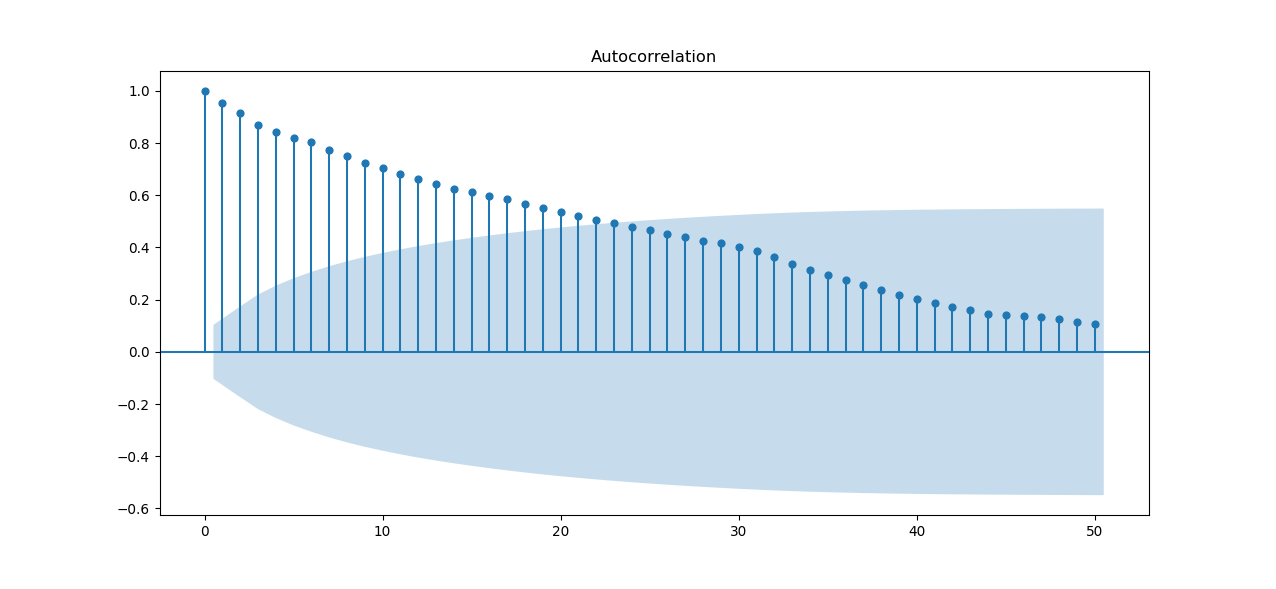

In [14]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

#plot autocorrelation function
fig = tsaplots.plot_acf(c_angle, lags=50)
plt.show()

In [15]:
my_length=len(c_angle)

In [16]:
import random
vec = np.arange(0,358)
box = np.zeros(359)
for i in vec:
    box[i] = random.uniform(0, 1)
box1 = (box * 360) -180
    
print(box1)

[  73.46683205   81.81853949 -120.07881639   91.34485476  140.53989409
  129.33198772  -24.72144405 -166.95306001  -41.39037353  100.6634322
  -63.21905023 -166.82965064  131.96304509 -128.89217297  167.96217372
   31.73528653   16.78703772  101.83418324  165.30325721 -126.88099744
  -28.59735843 -123.3822844  -177.23180294  -66.67909924  -70.56571717
  137.099069    -12.66212705 -164.96758887   52.84938056  -49.74407249
 -127.90811915   86.58239016  151.54565438   45.29319557  160.35143215
 -179.65032547  -32.94722506  151.83298452  177.46117479  -77.05155724
  -56.83289107 -125.19207107   36.34747086   56.82286227  -26.76134413
  -65.70311158 -125.43775865  -95.73189846 -106.95735694  -12.85860842
  -82.9741121    10.68636392  177.73643997  -87.72096235   44.97699335
 -175.91076282   27.8478423  -142.81966968  165.9501736   110.72042085
  -28.27862251  -86.85262653   31.28140282    7.16463834  -42.30702858
  165.48499817  159.60552604  -73.08216935 -145.10319676    5.03402231
   76.9

<IPython.core.display.Javascript object>


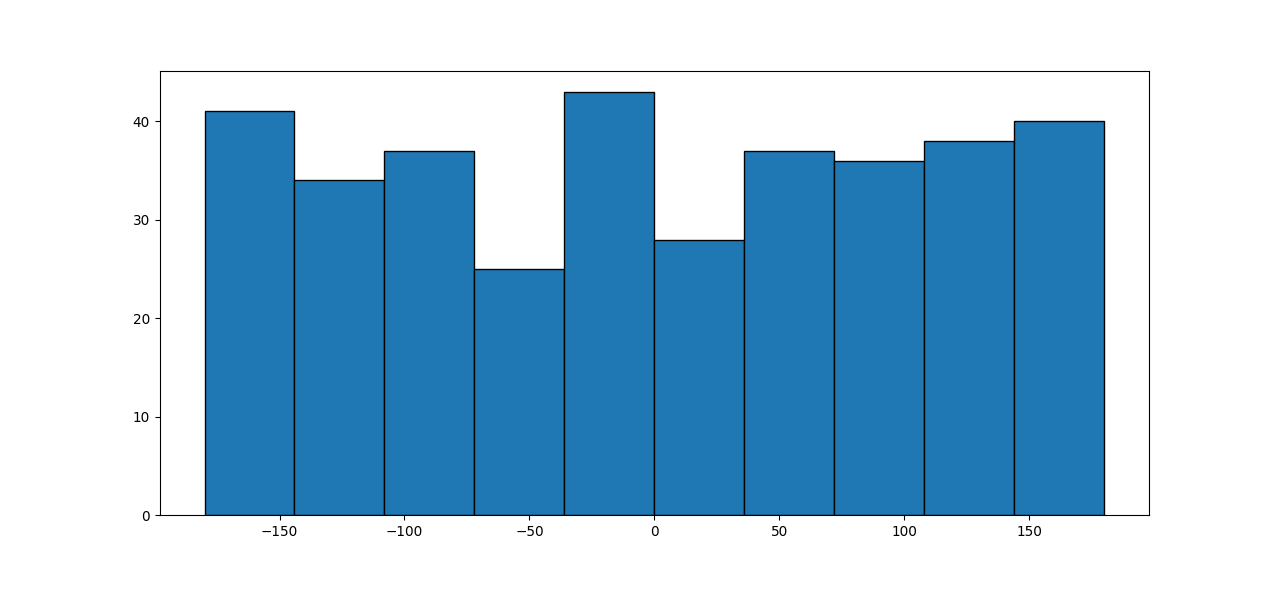

(array([41., 34., 37., 25., 43., 28., 37., 36., 38., 40.]),
 array([-1.80000000e+02, -1.44027428e+02, -1.08054856e+02, -7.20822833e+01,
        -3.61097110e+01, -1.37138781e-01,  3.58354335e+01,  7.18080057e+01,
         1.07780578e+02,  1.43753150e+02,  1.79725722e+02]),
 <BarContainer object of 10 artists>)

In [17]:

fig, ax = plt.subplots(1, 1)
ax.hist(box1, edgecolor = "black")



<IPython.core.display.Javascript object>


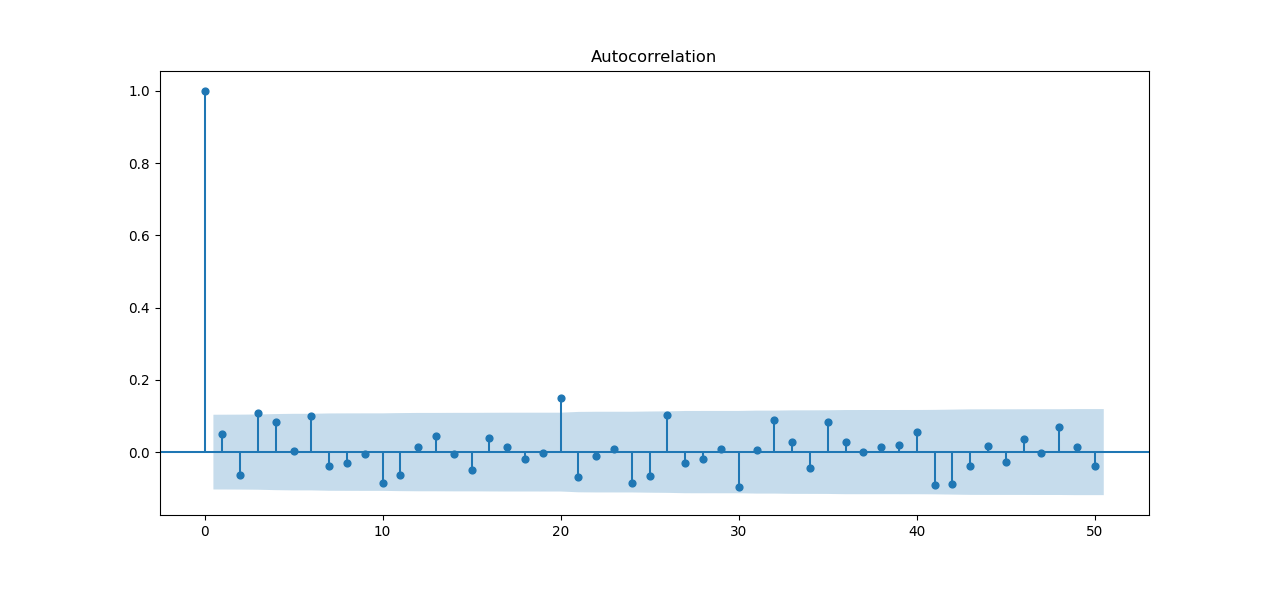

In [18]:
fig = tsaplots.plot_acf(box1, lags=50)
plt.show()
